In [1]:
import os, sys
import numpy as np
import pickle
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import json
import ROOT as rt
import fnmatch

## user define
sys.path.append('.')
sys.path.append('./Utils')
from Plotter import HistStack

from beeps import *

Welcome to JupyROOT 6.26/08


# Set config

In [2]:
# ERA="ee17"
# ERA="ee16pre"
# # ERA="mm18"
# ERA="em18"
# # DATE = '20230129_17_eleffmva'
# DATE = '20230301_18'
# # DATE = '20230130_18_dyhighworctight'
# # INPUTDIR = "/eos/user/h/hkwon/Run2/20230130_18_dyhighworctight/mm/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/20230301_18/em/"
import sys
ERA = sys.argv[1]
DATE = sys.argv[2]
INPUTDIR = sys.argv[3]

DUMP_PKL = True
DRAW_SR = True
RUN_SIDEBAND_MET = True
RUN_SIDEBAND_MASS = True
RUN_SIDEBAND_PT = True
DUMP_SIDEBAND_MET_PKL = True
DUMP_SIDEBAND_MASS_PKL = True
DUMP_SIDEBAND_PT_PKL = True
RUN_BTAG = False
EXPORT_VARIABLE = False

# # for dev
# ERA="em18"
# DATE = '20230514wp80_18'
# INPUTDIR = "/eos/user/h/hkwon/Run2/"+DATE+"/em/"


# Get input

In [3]:
lumi_all={
    "ee16pre":19520,
    "ee16post":16810,
    "ee17":41480,
    "ee18":59830,
    "mm16pre":19520,
    "mm16post":16810,
    "mm17":41480,
    "mm18":59830,    
#     "mm18":14000,    
    "em16pre":19520,
    "em16post":16810,
    "em17":41480,
    "em18":59830     
}

data_evts = {
    "ee16pre":652566543,
    "ee16post":287977113,
    "ee17":460041183,
    "ee18":1326465857,
    "mm16pre":458655573,
    "mm16post":327037312,
    "mm17":739073837,
#     "mm18":944842550,  #949352777 
    "mm18":949352777,  #949352777 
    "em16pre":1111222116,
    "em16post":615014425,
    "em17":1199115020,
#     "em18":2271308407   #2281001366  
    "em18":2281001366   #2281001366  
}

lumi=lumi_all[ERA]
print(ERA, lumi)

channel = ERA.replace("16pre", "")
channel = channel.replace("16post", "")
channel = channel.replace("17", "")
channel = channel.replace("18", "")

def get_df(root_file_name, unneccesary_columns):
    f = uproot.open(root_file_name)
    df = uproot.open(root_file_name)["Events_"+channel].arrays(library="pd")
    df_met_u = uproot.open(root_file_name)["Events_"+channel+"_met_u"].arrays(library="pd")
    df_met_d = uproot.open(root_file_name)["Events_"+channel+"_met_d"].arrays(library="pd")    
#     df_scale_u = uproot.open(root_file_name)["Events_"+channel+"_scale_u"].arrays(library="pd")
#     df_scale_d = uproot.open(root_file_name)["Events_"+channel+"_scale_d"].arrays(library="pd")
    info = uproot.open(root_file_name)["Info_"+channel].arrays(library="pd")
#     return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1), df_scale_u.drop(unneccesary_columns, axis=1), df_scale_d.drop(unneccesary_columns, axis=1)
    return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1)

unneccesary_columns = []
dic_input = {
    "ee16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/ee/",
    "mm16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/mm/",
    "em16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/em/",
    "ee16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/ee/",
    "mm16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/mm/",
    "em16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/em/",
    "ee17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/ee/",
    "mm17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/mm/",
    "em17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/em/",
    "ee18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/ee/",
    "mm18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/mm/",    
    "em18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/em/"        
#     "em18": "/eos/user/h/hkwon/Run2/20221120_18/em/"        
}
# input_dir = dic_input[ERA]
input_dir = INPUTDIR
f = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    f.extend(filenames)
    break

dic_tup={}
for file in tqdm(f):
    # file naming: flatNtuple_Preselect_WZ1.root, flatNtuple_Preselect_Zp-3700_CH-1345.root
    if not "flatNtuple" in file:
        continue
#     if channel=="mm" and (fnmatch.fnmatch(file, '*E*Run*') or fnmatch.fnmatch(file, '*M*RunB*') or fnmatch.fnmatch(file, '*M*RunC*') or fnmatch.fnmatch(file, '*M*RunD*')): #temp
    if channel=="mm" and fnmatch.fnmatch(file, '*E*Run*'): #temp
        continue
    if channel=="ee" and fnmatch.fnmatch(file, '*M*Run*'):
        continue
#     if channel=="em" and fnmatch.fnmatch(file, '*E*Run*'):
#         continue  

    if "Zp" in file:
        sample=file.split('_')[2]+"_"+file.split('_')[3]
    else:
        sample=file.split('_')[2]
    sample=sample.rstrip('.root')
    try:
        print(sample)
        dic_tup[sample]=get_df(input_dir+file, unneccesary_columns)   
    except:
        print(sample)
        beep()        
        if "Run" in sample: # check file corrupt
            raise    
# dic_tup

em18 59830


  0%|          | 0/288 [00:00<?, ?it/s]

DY0


  0%|          | 1/288 [00:00<02:54,  1.64it/s]

DY1


  1%|          | 2/288 [00:01<02:44,  1.73it/s]

DY10


  1%|          | 3/288 [00:01<02:27,  1.93it/s]

DY1000To15000


  1%|▏         | 4/288 [00:02<02:22,  1.99it/s]

DY11


  2%|▏         | 5/288 [00:02<02:20,  2.02it/s]

DY12


  2%|▏         | 6/288 [00:02<02:10,  2.16it/s]

DY13


  2%|▏         | 7/288 [00:03<02:05,  2.24it/s]

DY14


  3%|▎         | 8/288 [00:03<02:06,  2.21it/s]

DY15


  3%|▎         | 9/288 [00:04<02:03,  2.25it/s]

DY1500To20000


  3%|▎         | 10/288 [00:04<02:11,  2.11it/s]

DY16


  4%|▍         | 11/288 [00:05<02:09,  2.15it/s]

DY17


  4%|▍         | 12/288 [00:05<02:21,  1.96it/s]

DY18


  5%|▍         | 13/288 [00:06<02:21,  1.94it/s]

DY19


  5%|▍         | 14/288 [00:06<02:15,  2.03it/s]

DY2


  5%|▌         | 15/288 [00:07<02:09,  2.11it/s]

DY20


  6%|▌         | 16/288 [00:07<02:08,  2.12it/s]

DY2000To30000


  6%|▌         | 17/288 [00:08<02:09,  2.10it/s]

DY3


  6%|▋         | 18/288 [00:08<02:04,  2.17it/s]

DY4


  7%|▋         | 19/288 [00:09<02:06,  2.12it/s]

DY5


  7%|▋         | 20/288 [00:09<02:05,  2.13it/s]

DY500To7000


  7%|▋         | 21/288 [00:10<02:01,  2.20it/s]

DY6


  8%|▊         | 22/288 [00:10<02:06,  2.11it/s]

DY7


  8%|▊         | 23/288 [00:11<02:08,  2.06it/s]

DY700To8000


  8%|▊         | 24/288 [00:11<02:08,  2.06it/s]

DY8


  9%|▊         | 25/288 [00:12<02:15,  1.94it/s]

DY800To10000


  9%|▉         | 26/288 [00:12<02:22,  1.83it/s]

DY9


  9%|▉         | 27/288 [00:13<02:11,  1.98it/s]

E18RunA0


 10%|▉         | 28/288 [00:13<02:06,  2.06it/s]

E18RunA1


 10%|█         | 29/288 [00:14<02:12,  1.95it/s]

E18RunA10


 10%|█         | 30/288 [00:14<02:11,  1.96it/s]

E18RunA11


 11%|█         | 31/288 [00:15<02:06,  2.03it/s]

E18RunA12


 11%|█         | 32/288 [00:15<02:05,  2.04it/s]

E18RunA13


 11%|█▏        | 33/288 [00:16<02:13,  1.91it/s]

E18RunA14


 12%|█▏        | 34/288 [00:16<02:24,  1.76it/s]

E18RunA15


 12%|█▏        | 35/288 [00:17<02:25,  1.74it/s]

E18RunA16


 12%|█▎        | 36/288 [00:17<02:16,  1.85it/s]

E18RunA17


 13%|█▎        | 37/288 [00:18<02:14,  1.86it/s]

E18RunA18


 13%|█▎        | 38/288 [00:19<02:16,  1.83it/s]

E18RunA19


 14%|█▎        | 39/288 [00:19<02:13,  1.87it/s]

E18RunA2


 14%|█▍        | 40/288 [00:20<02:11,  1.89it/s]

E18RunA20


 14%|█▍        | 41/288 [00:20<02:02,  2.01it/s]

E18RunA21


 15%|█▍        | 42/288 [00:20<01:58,  2.07it/s]

E18RunA22


 15%|█▍        | 43/288 [00:21<01:55,  2.13it/s]

E18RunA3


 15%|█▌        | 44/288 [00:22<03:09,  1.29it/s]

E18RunA4


 16%|█▌        | 45/288 [00:23<02:52,  1.41it/s]

E18RunA5


 16%|█▌        | 46/288 [00:24<02:42,  1.49it/s]

E18RunA6


 16%|█▋        | 47/288 [00:24<02:27,  1.64it/s]

E18RunA7


 17%|█▋        | 48/288 [00:24<02:15,  1.77it/s]

E18RunA8


 17%|█▋        | 49/288 [00:25<02:08,  1.86it/s]

E18RunA9


 17%|█▋        | 50/288 [00:25<02:04,  1.91it/s]

E18RunB0


 18%|█▊        | 51/288 [00:26<02:15,  1.75it/s]

E18RunB1


 18%|█▊        | 52/288 [00:27<02:13,  1.76it/s]

E18RunB2


 18%|█▊        | 53/288 [00:27<02:12,  1.78it/s]

E18RunB3


 19%|█▉        | 54/288 [00:28<02:08,  1.83it/s]

E18RunB4


 19%|█▉        | 55/288 [00:28<02:05,  1.86it/s]

E18RunB5


 19%|█▉        | 56/288 [00:29<01:58,  1.96it/s]

E18RunB6


 20%|█▉        | 57/288 [00:29<02:06,  1.82it/s]

E18RunB7


 20%|██        | 58/288 [00:30<01:58,  1.95it/s]

E18RunC0


 20%|██        | 59/288 [00:30<02:00,  1.90it/s]

E18RunC1


 21%|██        | 60/288 [00:31<01:55,  1.97it/s]

E18RunC2


 21%|██        | 61/288 [00:31<01:52,  2.01it/s]

E18RunC3


 22%|██▏       | 62/288 [00:32<01:48,  2.09it/s]

E18RunC4


 22%|██▏       | 63/288 [00:32<01:46,  2.10it/s]

E18RunC5


 22%|██▏       | 64/288 [00:33<01:46,  2.11it/s]

E18RunC6


 23%|██▎       | 65/288 [00:33<01:48,  2.05it/s]

E18RunC7


 23%|██▎       | 66/288 [00:34<01:45,  2.11it/s]

E18RunC8


 23%|██▎       | 67/288 [00:34<01:44,  2.12it/s]

E18RunD0


 24%|██▎       | 68/288 [00:34<01:38,  2.22it/s]

E18RunD1


 24%|██▍       | 69/288 [00:35<01:40,  2.19it/s]

E18RunD10


 24%|██▍       | 70/288 [00:36<01:52,  1.93it/s]

E18RunD11


 25%|██▍       | 71/288 [00:36<01:48,  2.00it/s]

E18RunD12


 25%|██▌       | 72/288 [00:37<01:51,  1.94it/s]

E18RunD13


 25%|██▌       | 73/288 [00:37<01:50,  1.95it/s]

E18RunD14


 26%|██▌       | 74/288 [00:38<01:47,  1.99it/s]

E18RunD15


 26%|██▌       | 75/288 [00:38<01:47,  1.98it/s]

E18RunD16


 26%|██▋       | 76/288 [00:39<01:50,  1.92it/s]

E18RunD17


 27%|██▋       | 77/288 [00:39<01:52,  1.87it/s]

E18RunD18


 27%|██▋       | 78/288 [00:40<01:51,  1.89it/s]

E18RunD19


 27%|██▋       | 79/288 [00:40<01:48,  1.94it/s]

E18RunD2


 28%|██▊       | 80/288 [00:41<01:41,  2.05it/s]

E18RunD20


 28%|██▊       | 81/288 [00:41<01:33,  2.21it/s]

E18RunD21


 28%|██▊       | 82/288 [00:41<01:31,  2.25it/s]

E18RunD22


 29%|██▉       | 83/288 [00:42<01:48,  1.88it/s]

E18RunD23


 29%|██▉       | 84/288 [00:43<01:51,  1.82it/s]

E18RunD24


 30%|██▉       | 85/288 [00:43<01:46,  1.90it/s]

E18RunD25


 30%|██▉       | 86/288 [00:44<01:47,  1.89it/s]

E18RunD26


 30%|███       | 87/288 [00:44<01:44,  1.93it/s]

E18RunD27


 31%|███       | 88/288 [00:45<01:42,  1.94it/s]

E18RunD28


 31%|███       | 89/288 [00:45<01:42,  1.95it/s]

E18RunD29


 31%|███▏      | 90/288 [00:46<01:40,  1.98it/s]

E18RunD3


 32%|███▏      | 91/288 [00:46<01:37,  2.02it/s]

E18RunD30


 32%|███▏      | 92/288 [00:47<01:35,  2.04it/s]

E18RunD31


 32%|███▏      | 93/288 [00:47<01:41,  1.93it/s]

E18RunD32


 33%|███▎      | 94/288 [00:48<01:39,  1.95it/s]

E18RunD33


 33%|███▎      | 95/288 [00:48<01:38,  1.96it/s]

E18RunD34


 33%|███▎      | 96/288 [00:49<01:36,  1.99it/s]

E18RunD35


 34%|███▎      | 97/288 [00:49<01:36,  1.99it/s]

E18RunD4


 34%|███▍      | 98/288 [00:50<01:34,  2.01it/s]

E18RunD5


 34%|███▍      | 99/288 [00:50<01:34,  1.99it/s]

E18RunD6


 35%|███▍      | 100/288 [00:51<01:34,  2.00it/s]

E18RunD7


 35%|███▌      | 101/288 [00:51<01:33,  2.00it/s]

E18RunD8


 35%|███▌      | 102/288 [00:52<01:31,  2.03it/s]

E18RunD9


 36%|███▌      | 103/288 [00:52<01:27,  2.13it/s]

M18RunA0


 36%|███▌      | 104/288 [00:53<01:28,  2.08it/s]

M18RunA1


 36%|███▋      | 105/288 [00:53<01:28,  2.07it/s]

M18RunA2


 37%|███▋      | 106/288 [00:54<01:28,  2.07it/s]

M18RunA3


 37%|███▋      | 107/288 [00:54<01:30,  2.00it/s]

M18RunA4


 38%|███▊      | 108/288 [00:55<01:29,  2.01it/s]

M18RunA5


 38%|███▊      | 109/288 [00:55<01:29,  2.01it/s]

M18RunA6


 38%|███▊      | 110/288 [00:56<01:24,  2.11it/s]

M18RunA7


 39%|███▊      | 111/288 [00:56<01:19,  2.22it/s]

M18RunA8


 39%|███▉      | 112/288 [00:57<01:26,  2.04it/s]

M18RunA9


 39%|███▉      | 113/288 [00:57<01:21,  2.13it/s]

M18RunB0


 40%|███▉      | 114/288 [00:57<01:16,  2.28it/s]

M18RunB1


 40%|███▉      | 115/288 [00:58<01:15,  2.30it/s]

M18RunB2


 40%|████      | 116/288 [00:58<01:11,  2.40it/s]

M18RunB3


 41%|████      | 117/288 [00:59<01:10,  2.44it/s]

M18RunB4


 41%|████      | 118/288 [00:59<01:08,  2.47it/s]

M18RunB5


 41%|████▏     | 119/288 [00:59<01:08,  2.47it/s]

M18RunC0


 42%|████▏     | 120/288 [01:00<01:10,  2.38it/s]

M18RunC1


 42%|████▏     | 121/288 [01:00<01:09,  2.39it/s]

M18RunC2


 42%|████▏     | 122/288 [01:01<01:15,  2.20it/s]

M18RunC3


 43%|████▎     | 123/288 [01:01<01:18,  2.10it/s]

M18RunC4


 43%|████▎     | 124/288 [01:02<01:18,  2.09it/s]

M18RunC5


 43%|████▎     | 125/288 [01:02<01:16,  2.13it/s]

M18RunC6


 44%|████▍     | 126/288 [01:03<01:12,  2.24it/s]

M18RunD0


 44%|████▍     | 127/288 [01:03<01:14,  2.16it/s]

M18RunD1


 44%|████▍     | 128/288 [01:04<01:13,  2.17it/s]

M18RunD10


 45%|████▍     | 129/288 [01:04<01:14,  2.13it/s]

M18RunD11


 45%|████▌     | 130/288 [01:04<01:12,  2.16it/s]

M18RunD12


 45%|████▌     | 131/288 [01:05<01:08,  2.28it/s]

M18RunD13


 46%|████▌     | 132/288 [01:05<01:09,  2.23it/s]

M18RunD14


 46%|████▌     | 133/288 [01:06<01:11,  2.16it/s]

M18RunD15


 47%|████▋     | 134/288 [01:06<01:16,  2.02it/s]

M18RunD16


 47%|████▋     | 135/288 [01:07<01:17,  1.97it/s]

M18RunD17


 47%|████▋     | 136/288 [01:08<01:20,  1.90it/s]

M18RunD18


 48%|████▊     | 137/288 [01:08<01:16,  1.97it/s]

M18RunD19


 48%|████▊     | 138/288 [01:09<01:19,  1.89it/s]

M18RunD2


 48%|████▊     | 139/288 [01:09<01:21,  1.83it/s]

M18RunD20


 49%|████▊     | 140/288 [01:10<01:19,  1.86it/s]

M18RunD3


 49%|████▉     | 141/288 [01:10<01:15,  1.95it/s]

M18RunD4


 49%|████▉     | 142/288 [01:11<01:14,  1.97it/s]

M18RunD5


 50%|████▉     | 143/288 [01:11<01:13,  1.98it/s]

M18RunD6


 50%|█████     | 144/288 [01:12<01:11,  2.02it/s]

M18RunD7


 50%|█████     | 145/288 [01:12<01:10,  2.03it/s]

M18RunD8


 51%|█████     | 146/288 [01:13<01:08,  2.06it/s]

M18RunD9


 51%|█████     | 147/288 [01:13<01:03,  2.21it/s]

TT0


 51%|█████▏    | 148/288 [01:17<03:46,  1.62s/it]

TT1


 52%|█████▏    | 149/288 [01:21<05:00,  2.16s/it]

TT10


 52%|█████▏    | 150/288 [01:25<06:12,  2.70s/it]

TT11


 52%|█████▏    | 151/288 [01:28<06:39,  2.92s/it]

TT12


 53%|█████▎    | 152/288 [01:31<06:29,  2.86s/it]

TT13


 53%|█████▎    | 153/288 [01:34<06:28,  2.88s/it]

TT14


 53%|█████▎    | 154/288 [01:36<06:10,  2.76s/it]

TT15


 54%|█████▍    | 155/288 [01:38<05:10,  2.34s/it]

TT2


 54%|█████▍    | 156/288 [01:41<06:09,  2.80s/it]

TT3


 55%|█████▍    | 157/288 [01:44<06:13,  2.85s/it]

TT4


 55%|█████▍    | 158/288 [01:48<06:33,  3.03s/it]

TT5


 55%|█████▌    | 159/288 [01:51<06:46,  3.15s/it]

TT6


 56%|█████▌    | 160/288 [01:55<06:55,  3.25s/it]

TT7


 56%|█████▌    | 161/288 [01:57<06:31,  3.08s/it]

TT8


 56%|█████▋    | 162/288 [02:00<06:00,  2.86s/it]

TT9


 57%|█████▋    | 163/288 [02:02<05:48,  2.79s/it]

TTDown0


 57%|█████▋    | 164/288 [02:06<06:03,  2.93s/it]

TTDown1


 57%|█████▋    | 165/288 [02:09<06:08,  2.99s/it]

TTDown2


 58%|█████▊    | 166/288 [02:13<06:30,  3.20s/it]

TTDown3


 58%|█████▊    | 167/288 [02:16<06:49,  3.39s/it]

TTDown4


 58%|█████▊    | 168/288 [02:20<06:45,  3.38s/it]

TTDown5
TTDown5


 59%|█████▊    | 169/288 [02:20<04:48,  2.42s/it]

TTSemi0


 59%|█████▉    | 170/288 [02:20<03:36,  1.84s/it]

TTSemi1


 59%|█████▉    | 171/288 [02:21<02:46,  1.43s/it]

TTSemi10


 60%|█████▉    | 172/288 [02:22<02:52,  1.49s/it]

TTSemi11


 60%|██████    | 173/288 [02:23<02:16,  1.18s/it]

TTSemi12


 60%|██████    | 174/288 [02:23<01:50,  1.03it/s]

TTSemi13


 61%|██████    | 175/288 [02:24<01:32,  1.22it/s]

TTSemi14


 61%|██████    | 176/288 [02:24<01:20,  1.39it/s]

TTSemi15


 61%|██████▏   | 177/288 [02:25<01:13,  1.51it/s]

TTSemi16


 62%|██████▏   | 178/288 [02:25<01:07,  1.62it/s]

TTSemi17


 62%|██████▏   | 179/288 [02:26<01:03,  1.71it/s]

TTSemi18


 62%|██████▎   | 180/288 [02:26<01:00,  1.78it/s]

TTSemi19


 63%|██████▎   | 181/288 [02:27<01:00,  1.76it/s]

TTSemi2


 63%|██████▎   | 182/288 [02:27<00:57,  1.83it/s]

TTSemi20


 64%|██████▎   | 183/288 [02:28<00:55,  1.89it/s]

TTSemi21


 64%|██████▍   | 184/288 [02:29<00:54,  1.89it/s]

TTSemi22


 64%|██████▍   | 185/288 [02:29<00:51,  2.00it/s]

TTSemi23


 65%|██████▍   | 186/288 [02:30<01:20,  1.27it/s]

TTSemi24


 65%|██████▍   | 187/288 [02:32<01:37,  1.04it/s]

TTSemi25


 65%|██████▌   | 188/288 [02:32<01:25,  1.17it/s]

TTSemi26


 66%|██████▌   | 189/288 [02:33<01:14,  1.32it/s]

TTSemi27


 66%|██████▌   | 190/288 [02:33<01:06,  1.48it/s]

TTSemi28


 66%|██████▋   | 191/288 [02:34<00:58,  1.66it/s]

TTSemi29


 67%|██████▋   | 192/288 [02:34<00:54,  1.76it/s]

TTSemi3


 67%|██████▋   | 193/288 [02:35<00:50,  1.87it/s]

TTSemi30


 67%|██████▋   | 194/288 [02:35<00:50,  1.85it/s]

TTSemi31


 68%|██████▊   | 195/288 [02:36<00:51,  1.82it/s]

TTSemi32


 68%|██████▊   | 196/288 [02:37<00:55,  1.65it/s]

TTSemi33


 68%|██████▊   | 197/288 [02:37<00:54,  1.67it/s]

TTSemi34


 69%|██████▉   | 198/288 [02:38<00:51,  1.76it/s]

TTSemi35


 69%|██████▉   | 199/288 [02:38<00:47,  1.86it/s]

TTSemi36


 69%|██████▉   | 200/288 [02:39<00:44,  1.99it/s]

TTSemi37


 70%|██████▉   | 201/288 [02:39<00:43,  2.02it/s]

TTSemi38


 70%|███████   | 202/288 [02:39<00:40,  2.14it/s]

TTSemi39


 70%|███████   | 203/288 [02:40<00:40,  2.11it/s]

TTSemi4


 71%|███████   | 204/288 [02:41<01:04,  1.29it/s]

TTSemi5


 71%|███████   | 205/288 [02:42<00:56,  1.47it/s]

TTSemi6


 72%|███████▏  | 206/288 [02:42<00:50,  1.61it/s]

TTSemi7


 72%|███████▏  | 207/288 [02:43<00:46,  1.73it/s]

TTSemi8


 72%|███████▏  | 208/288 [02:43<00:41,  1.93it/s]

TTSemi9


 73%|███████▎  | 209/288 [02:44<00:39,  2.00it/s]

TTUp0


 73%|███████▎  | 210/288 [02:48<02:08,  1.64s/it]

TTUp1


 73%|███████▎  | 211/288 [02:51<02:45,  2.15s/it]

TTUp2


 74%|███████▎  | 212/288 [02:55<03:09,  2.49s/it]

TTUp3


 74%|███████▍  | 213/288 [02:58<03:22,  2.69s/it]

TTUp4


 74%|███████▍  | 214/288 [03:01<03:33,  2.89s/it]

TTUp5


 75%|███████▍  | 215/288 [03:10<05:37,  4.63s/it]

TTZ0


 75%|███████▌  | 216/288 [03:11<04:21,  3.63s/it]

TTZ1


 75%|███████▌  | 217/288 [03:12<03:24,  2.88s/it]

TTZ2


 76%|███████▌  | 218/288 [03:13<02:33,  2.19s/it]

TThdampDown0


 76%|███████▌  | 219/288 [03:16<02:50,  2.48s/it]

TThdampDown1


 76%|███████▋  | 220/288 [03:19<03:08,  2.77s/it]

TThdampDown2


 77%|███████▋  | 221/288 [03:23<03:24,  3.05s/it]

TThdampDown3


 77%|███████▋  | 222/288 [03:28<03:49,  3.47s/it]

TThdampDown4


 77%|███████▋  | 223/288 [03:31<03:41,  3.41s/it]

TThdampDown5


 78%|███████▊  | 224/288 [03:34<03:26,  3.22s/it]

TThdampUp0


 78%|███████▊  | 225/288 [03:38<03:38,  3.46s/it]

TThdampUp1


 78%|███████▊  | 226/288 [03:42<03:44,  3.62s/it]

TThdampUp2


 79%|███████▉  | 227/288 [03:47<04:03,  4.00s/it]

TThdampUp3


 79%|███████▉  | 228/288 [03:51<04:06,  4.11s/it]

TThdampUp4


 80%|███████▉  | 229/288 [03:53<03:20,  3.40s/it]

TW0


 80%|███████▉  | 230/288 [03:53<02:25,  2.51s/it]

TW1


 80%|████████  | 231/288 [03:54<01:49,  1.92s/it]

TW2


 81%|████████  | 232/288 [03:54<01:22,  1.47s/it]

TW3


 81%|████████  | 233/288 [03:55<01:05,  1.19s/it]

TW4


 81%|████████▏ | 234/288 [03:55<00:56,  1.06s/it]

TW5


 82%|████████▏ | 235/288 [03:56<00:47,  1.12it/s]

TWa0


 82%|████████▏ | 236/288 [03:56<00:41,  1.26it/s]

TWa1


 82%|████████▏ | 237/288 [03:57<00:38,  1.33it/s]

TWa2


 83%|████████▎ | 238/288 [03:58<00:33,  1.47it/s]

WW0


 83%|████████▎ | 239/288 [03:59<00:37,  1.30it/s]

WW1


 83%|████████▎ | 240/288 [03:59<00:36,  1.32it/s]

WW2


 84%|████████▎ | 241/288 [04:00<00:36,  1.28it/s]

WW3


 84%|████████▍ | 242/288 [04:01<00:37,  1.24it/s]

WZ0


 84%|████████▍ | 243/288 [04:02<00:37,  1.22it/s]

WZ1


 85%|████████▍ | 244/288 [04:02<00:33,  1.33it/s]

WZQQ0


 85%|████████▌ | 245/288 [04:03<00:29,  1.47it/s]

WZQQ1


 85%|████████▌ | 246/288 [04:03<00:26,  1.61it/s]

WZQQ2


 86%|████████▌ | 247/288 [04:04<00:23,  1.73it/s]

ZZ0


 86%|████████▌ | 248/288 [04:04<00:23,  1.72it/s]

ZZ1


 86%|████████▋ | 249/288 [04:05<00:21,  1.83it/s]

ZZ2


 87%|████████▋ | 250/288 [04:05<00:20,  1.88it/s]

ZZ3


 87%|████████▋ | 251/288 [04:06<00:18,  1.99it/s]

ZZ4


 88%|████████▊ | 252/288 [04:06<00:18,  1.95it/s]

ZZ5


 88%|████████▊ | 253/288 [04:07<00:17,  2.04it/s]

ZZ6


 88%|████████▊ | 254/288 [04:07<00:15,  2.13it/s]

Zp-1700_CH-345


 89%|████████▊ | 255/288 [04:08<00:19,  1.68it/s]

Zp-1700_CH-595


 89%|████████▉ | 256/288 [04:09<00:21,  1.46it/s]

Zp-1700_CH-845


 89%|████████▉ | 257/288 [04:10<00:26,  1.16it/s]

Zp-2100_CH-345


 90%|████████▉ | 258/288 [04:11<00:27,  1.09it/s]

Zp-2100_CH-595


 90%|████████▉ | 259/288 [04:12<00:26,  1.09it/s]

Zp-2100_CH-845


 90%|█████████ | 260/288 [04:13<00:27,  1.02it/s]

Zp-2500_CH-345


 91%|█████████ | 261/288 [04:14<00:26,  1.01it/s]

Zp-2500_CH-595


 91%|█████████ | 262/288 [04:16<00:27,  1.05s/it]

Zp-2500_CH-845


 91%|█████████▏| 263/288 [04:17<00:25,  1.01s/it]

Zp-2900_CH-1095


 92%|█████████▏| 264/288 [04:18<00:24,  1.00s/it]

Zp-2900_CH-1345


 92%|█████████▏| 265/288 [04:19<00:23,  1.02s/it]

Zp-2900_CH-345


 92%|█████████▏| 266/288 [04:20<00:21,  1.01it/s]

Zp-2900_CH-595


 93%|█████████▎| 267/288 [04:21<00:22,  1.06s/it]

Zp-2900_CH-845


 93%|█████████▎| 268/288 [04:23<00:27,  1.37s/it]

Zp-3300_CH-1095


 93%|█████████▎| 269/288 [04:24<00:26,  1.38s/it]

Zp-3300_CH-1345


 94%|█████████▍| 270/288 [04:25<00:22,  1.27s/it]

Zp-3300_CH-1595


 94%|█████████▍| 271/288 [04:26<00:21,  1.24s/it]

Zp-3300_CH-345


 94%|█████████▍| 272/288 [04:28<00:21,  1.34s/it]

Zp-3300_CH-595


 95%|█████████▍| 273/288 [04:29<00:18,  1.23s/it]

Zp-3300_CH-845


 95%|█████████▌| 274/288 [04:30<00:16,  1.14s/it]

Zp-3700_CH-1095


 95%|█████████▌| 275/288 [04:31<00:14,  1.11s/it]

Zp-3700_CH-1345


 96%|█████████▌| 276/288 [04:32<00:13,  1.14s/it]

Zp-3700_CH-1595


 96%|█████████▌| 277/288 [04:34<00:13,  1.26s/it]

Zp-3700_CH-1845


 97%|█████████▋| 278/288 [04:35<00:11,  1.18s/it]

Zp-3700_CH-345


 97%|█████████▋| 279/288 [04:36<00:10,  1.11s/it]

Zp-3700_CH-595


 97%|█████████▋| 280/288 [04:37<00:08,  1.07s/it]

Zp-3700_CH-845


 98%|█████████▊| 281/288 [04:38<00:07,  1.08s/it]

Zp-4100_CH-1095


 98%|█████████▊| 282/288 [04:39<00:06,  1.07s/it]

Zp-4100_CH-1345


 98%|█████████▊| 283/288 [04:40<00:05,  1.04s/it]

Zp-4100_CH-1595


 99%|█████████▊| 284/288 [04:41<00:04,  1.04s/it]

Zp-4100_CH-1845


 99%|█████████▉| 285/288 [04:42<00:03,  1.03s/it]

Zp-4100_CH-345


 99%|█████████▉| 286/288 [04:43<00:02,  1.00s/it]

Zp-4100_CH-595


100%|█████████▉| 287/288 [04:44<00:00,  1.00it/s]

Zp-4100_CH-845


100%|██████████| 288/288 [04:45<00:00,  1.01it/s]


In [4]:
beep_ok()

In [5]:
# for key in dic_tup:
#     print(key)

In [6]:
# get x-sec
dic_xsec={}
with open('config/CrossSection.json') as json_file:
    data = json.load(json_file)
    dic_xsec=data
print(dic_xsec)

{'Data': 1, 'DY': 6077.22, 'DY500To700': 0.2558, 'DY700To800': 0.04023, 'DY800To1000': 0.03406, 'DY1000To1500': 0.01828, 'DY1500To2000': 0.002367, 'DY2000To3000': 0.0005409, 'TT': 88.29, 'TTUp': 88.29, 'TTDown': 88.29, 'TThdampUp': 88.29, 'TThdampDown': 88.29, 'TTSemi': 365.34, 'TTZ': 0.2432, 'top': 34.91, 'antitop': 34.91, 'WW': 10.48, 'WZ': 5.052, 'ZZ': 0.6008, 'Zp-1700_CH-345': 0.03523, 'Zp-1700_CH-595': 0.03523, 'Zp-1700_CH-845': 0.03523, 'Zp-2100_CH-345': 0.01198, 'Zp-2100_CH-595': 0.01198, 'Zp-2100_CH-845': 0.01198, 'Zp-2500_CH-345': 0.004396, 'Zp-2500_CH-595': 0.004396, 'Zp-2500_CH-845': 0.004396, 'Zp-2500_CH-1095': 0.004396, 'Zp-2900_CH-345': 0.001768, 'Zp-2900_CH-595': 0.001768, 'Zp-2900_CH-845': 0.001768, 'Zp-2900_CH-1095': 0.001768, 'Zp-2900_CH-1345': 0.001768, 'Zp-3300_CH-345': 0.000729, 'Zp-3300_CH-595': 0.000729, 'Zp-3300_CH-845': 0.000729, 'Zp-3300_CH-1095': 0.000729, 'Zp-3300_CH-1345': 0.000729, 'Zp-3300_CH-1595': 0.000729, 'Zp-3700_CH-345': 0.00031, 'Zp-3700_CH-595': 0

In [7]:
Data_concat, TT_concat, TTSemi_concat, TTZ_concat, DY_concat, top_concat, antitop_concat, WW_concat, WZ_concat, ZZ_concat = ([] for i in range(10))
Data_concat_met_u, TT_concat_met_u, TTSemi_concat_met_u, TTZ_concat_met_u, DY_concat_met_u, top_concat_met_u, antitop_concat_met_u, WW_concat_met_u, WZ_concat_met_u, ZZ_concat_met_u = ([] for i in range(10))
Data_concat_met_d, TT_concat_met_d, TTSemi_concat_met_d, TTZ_concat_met_d, DY_concat_met_d, top_concat_met_d, antitop_concat_met_d, WW_concat_met_d, WZ_concat_met_d, ZZ_concat_met_d = ([] for i in range(10))
Data_concat_scale_u, TT_concat_scale_u, TTSemi_concat_scale_u, TTZ_concat_scale_u, DY_concat_scale_u, top_concat_scale_u, antitop_concat_scale_u, WW_concat_scale_u, WZ_concat_scale_u, ZZ_concat_scale_u = ([] for i in range(10))
Data_concat_scale_d, TT_concat_scale_d, TTSemi_concat_scale_d, TTZ_concat_scale_d, DY_concat_scale_d, top_concat_scale_d, antitop_concat_scale_d, WW_concat_scale_d, WZ_concat_scale_d, ZZ_concat_scale_d = ([] for i in range(10))
TTUp_concat, TTDown_concat, TThdampUp_concat, TThdampDown_concat = ([] for i in range(4)) 
TTUp_concat_met_u, TTDown_concat_met_u, TThdampUp_concat_met_u, TThdampDown_concat_met_u = ([] for i in range(4)) 
TTUp_concat_met_d, TTDown_concat_met_d, TThdampUp_concat_met_d, TThdampDown_concat_met_d = ([] for i in range(4)) 

Data_nevts, TT_nevts, TTSemi_nevts, TTZ_nevts, DY_nevts, top_nevts, antitop_nevts, WW_nevts, WZ_nevts, ZZ_nevts = ([] for i in range(10))
TTUp_nevts, TTDown_nevts, TThdampUp_nevts, TThdampDown_nevts = ([] for i in range(4))

merged_dic_df={}
for key in dic_tup:
    if fnmatch.fnmatch(key, 'DY?') or fnmatch.fnmatch(key, 'DY1?'):
#         print(key)
#         print(dic_tup[key][0])
        DY_concat.append(dic_tup[key][1])
        DY_concat_met_u.append(dic_tup[key][2])
        DY_concat_met_d.append(dic_tup[key][3])        
#         DY_concat_scale_u.append(dic_tup[key][4])
#         DY_concat_scale_d.append(dic_tup[key][5])
        DY_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, 'TT?') or fnmatch.fnmatch(key, 'TT1?'):
#         print("TT", key)
#         print(dic_tup[key][0])
        TT_concat.append(dic_tup[key][1])
        TT_concat_met_u.append(dic_tup[key][2])
        TT_concat_met_d.append(dic_tup[key][3])
#         TT_concat_scale_u.append(dic_tup[key][4])
#         TT_concat_scale_d.append(dic_tup[key][5])
        TT_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TThdampUp?') or fnmatch.fnmatch(key, 'TThdampUp1?'):
#         print(key)
#         print(dic_tup[key][0])
        TThdampUp_concat.append(dic_tup[key][1])
        TThdampUp_concat_met_u.append(dic_tup[key][2])
        TThdampUp_concat_met_d.append(dic_tup[key][3])
        TThdampUp_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TThdampDown?') or fnmatch.fnmatch(key, 'TThdampDown1?'):
#         print(key)
#         print(dic_tup[key][0])
        TThdampDown_concat.append(dic_tup[key][1])
        TThdampDown_concat_met_u.append(dic_tup[key][2])
        TThdampDown_concat_met_d.append(dic_tup[key][3])
        TThdampDown_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTUp?') or fnmatch.fnmatch(key, 'TTUp1?'):
#         print(key)
#         print(dic_tup[key][0])
        TTUp_concat.append(dic_tup[key][1])
        TTUp_concat_met_u.append(dic_tup[key][2])
        TTUp_concat_met_d.append(dic_tup[key][3])
        TTUp_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTDown?') or fnmatch.fnmatch(key, 'TTDown1?'):
#         print(key)
#         print(dic_tup[key][0])
        TTDown_concat.append(dic_tup[key][1])
        TTDown_concat_met_u.append(dic_tup[key][2])
        TTDown_concat_met_d.append(dic_tup[key][3])
        TTDown_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTSemi*'):
#         print(key)
#         print(dic_tup[key][0])
        TTSemi_concat.append(dic_tup[key][1])
        TTSemi_concat_met_u.append(dic_tup[key][2])
        TTSemi_concat_met_d.append(dic_tup[key][3])
#         TTSemi_concat_scale_u.append(dic_tup[key][4])
#         TTSemi_concat_scale_d.append(dic_tup[key][5])
        TTSemi_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTZ*'):
#         print(key)
#         print(dic_tup[key][0])
        TTZ_concat.append(dic_tup[key][1])
        TTZ_concat_met_u.append(dic_tup[key][2])
        TTZ_concat_met_d.append(dic_tup[key][3])
#         TTZ_concat_scale_u.append(dic_tup[key][4])
#         TTZ_concat_scale_d.append(dic_tup[key][5])
        TTZ_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TW?'):
#         print(key)
#         print(dic_tup[key][0])
        top_concat.append(dic_tup[key][1])
        top_concat_met_u.append(dic_tup[key][2])
        top_concat_met_d.append(dic_tup[key][3])
#         top_concat_scale_u.append(dic_tup[key][4])
#         top_concat_scale_d.append(dic_tup[key][5])
        top_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, 'TWa?'):
#         print(key)
#         print(dic_tup[key][0])
        antitop_concat.append(dic_tup[key][1])
        antitop_concat_met_u.append(dic_tup[key][2])
        antitop_concat_met_d.append(dic_tup[key][3])
#         antitop_concat_scale_u.append(dic_tup[key][4])
#         antitop_concat_scale_d.append(dic_tup[key][5])
        antitop_nevts.append(dic_tup[key][0]) 
    if fnmatch.fnmatch(key, 'WW*'):
        WW_concat.append(dic_tup[key][1])
        WW_concat_met_u.append(dic_tup[key][2])
        WW_concat_met_d.append(dic_tup[key][3])
#         WW_concat_scale_u.append(dic_tup[key][4])
#         WW_concat_scale_d.append(dic_tup[key][5])
        WW_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, 'WZ*'):
        WZ_concat.append(dic_tup[key][1])
        WZ_concat_met_u.append(dic_tup[key][2])
        WZ_concat_met_d.append(dic_tup[key][3])
#         WZ_concat_scale_u.append(dic_tup[key][4])
#         WZ_concat_scale_d.append(dic_tup[key][5])
        WZ_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'ZZ*'):
        ZZ_concat.append(dic_tup[key][1])
        ZZ_concat_met_u.append(dic_tup[key][2])
        ZZ_concat_met_d.append(dic_tup[key][3])
#         ZZ_concat_scale_u.append(dic_tup[key][4])
#         ZZ_concat_scale_d.append(dic_tup[key][5])
        ZZ_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, '*Run*'):
        Data_concat.append(dic_tup[key][1])
        Data_concat_met_u.append(dic_tup[key][2])
        Data_concat_met_d.append(dic_tup[key][3])
#         Data_concat_scale_u.append(dic_tup[key][4])
#         Data_concat_scale_d.append(dic_tup[key][5])
        Data_nevts.append(dic_tup[key][0]) 
    if fnmatch.fnmatch(key, 'Zp*'): 
        merged_dic_df[key]=dic_tup[key]
    if fnmatch.fnmatch(key, 'DY*To*'): 
        merged_dic_df[key]=dic_tup[key]
#         print("high", key)

In [8]:
# free memory 
dic_tup.clear()

In [9]:
totalinput = """
######################################################
####   Total input number of events (sumweight)   ####
######################################################
"""

print(totalinput)
if TT_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d)
    tmp = "TT: "+str(sum(TT_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if TThdampUp_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TThdampUp']=sum(TThdampUp_nevts), pd.concat(TThdampUp_concat), pd.concat(TThdampUp_concat_met_u), pd.concat(TThdampUp_concat_met_d)
    tmp = "TThdampUp: "+str(sum(TThdampUp_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if TThdampDown_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TThdampDown']=sum(TThdampDown_nevts), pd.concat(TThdampDown_concat), pd.concat(TThdampDown_concat_met_u), pd.concat(TThdampDown_concat_met_d)
    tmp = "TThdampDown: "+str(sum(TThdampDown_nevts))
    print(tmp)
    totalinput+=tmp+"\n"    
if TTUp_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TTUp']=sum(TTUp_nevts), pd.concat(TTUp_concat), pd.concat(TTUp_concat_met_u), pd.concat(TTUp_concat_met_d)
    tmp = "TTUp: "+str(sum(TTUp_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if TTDown_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TTDown']=sum(TTDown_nevts), pd.concat(TTDown_concat), pd.concat(TTDown_concat_met_u), pd.concat(TTDown_concat_met_d)
    tmp = "TTDown: "+str(sum(TTDown_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if TTSemi_concat:
#     merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d), pd.concat(TTSemi_concat_scale_u), pd.concat(TTSemi_concat_scale_d)
    merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d)
    tmp = "TTSemi: "+str(sum(TTSemi_nevts))
    print(tmp)
    totalinput+=tmp+"\n"    
if TTZ_concat:
#     merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d), pd.concat(TTZ_concat_scale_u), pd.concat(TTZ_concat_scale_d)
    merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d)
    tmp = "TTZ: "+str(sum(TTZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if DY_concat:
#     merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d), pd.concat(DY_concat_scale_u), pd.concat(DY_concat_scale_d)
    merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d)
    tmp = "DY: "+str(sum(DY_nevts))
    print(tmp)
    totalinput+=tmp+"\n"    
if top_concat:
    df=pd.concat(top_concat)
#     merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d), pd.concat(top_concat_scale_u), pd.concat(top_concat_scale_d)
    merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d)
    tmp = "top: "+str(sum(top_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if antitop_concat:
    df=pd.concat(antitop_concat)
#     merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d), pd.concat(antitop_concat_scale_u), pd.concat(antitop_concat_scale_d)
    merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d)
    tmp = "antitop: "+str(sum(antitop_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if ZZ_concat:
    df=pd.concat(ZZ_concat)
#     merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d), pd.concat(ZZ_concat_scale_u), pd.concat(ZZ_concat_scale_d)
    merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d)
    tmp = "ZZ: "+str(sum(ZZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if WZ_concat:
    df=pd.concat(WZ_concat)
#     merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d), pd.concat(WZ_concat_scale_u), pd.concat(WZ_concat_scale_d)
    merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d)
    tmp = "WZ: "+str(sum(WZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if WW_concat:
    df=pd.concat(WW_concat)
#     merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d), pd.concat(WW_concat_scale_u), pd.concat(WW_concat_scale_d)
    merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d)
    tmp = "WW: "+str(sum(WW_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if Data_concat:
#     merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d), pd.concat(Data_concat_scale_u), pd.concat(Data_concat_scale_d)
    merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d)
    tmp = "Data: "+str(sum(Data_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
# merged_dic_df["Zp-2500"]=dic_tup["Zp-2500"][0], dic_tup["Zp-2500"][1] 



######################################################
####   Total input number of events (sumweight)   ####
######################################################

TT: 143848848
TThdampUp: 53803428
TThdampDown: 58968886
TTUp: 56603364
TTDown: 51971956
TTSemi: 472557630
TTZ: 9651834
DY: 128601645
top: 7955614
antitop: 7748690
ZZ: 56766176
WZ: 24303029
WW: 9956710
Data: 2271308407


In [10]:
os.system("mkdir -p "+DATE+"/Presel/"+ERA)
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'w') as f:
    f.write(totalinput)

In [11]:
print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts))

# try:
#    if data_evts[ERA]!=sum(Data_nevts):
#        raise ValueError('Data events missing!')
# except (ValueError, IndexError):
#    beep()
#    print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts)) 
#    raise

expected: 2281001366 , while:  2271308407


In [12]:
# # temp!!
for key in merged_dic_df:
    df = merged_dic_df[key][1]
    df_met_u = merged_dic_df[key][2]
    df_met_d = merged_dic_df[key][3]    
#     df_scale_u = merged_dic_df[key][4]
#     df_scale_d = merged_dic_df[key][5]
#     print(df[df.isin([np.inf, -np.inf]).any(1)])
    if df.isnull().values.any():
        print("Warning, nan in",key)
        i = df[df.isin([np.nan, np.inf, -np.inf]).any(1)].index
        print(i)
        df_new = df.drop(i)
        df_met_u_new = df_met_u.drop(i)
        df_met_d_new = df_met_d.drop(i)
#         print(df_new.isnull().values.any())
        #workaround for tuple assignment
#         merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new, df_scale_u, df_scale_d
        merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new
        


In [13]:
sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre', 'trigSF_pre']
# sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre']
eventweights = """
####################################################
####       event weights (normalization)        ####
####################################################
"""

def get_dic_with_weight(merged_dic_df):
    dic_df={}
    dic_df_met_u={}
    dic_df_met_d={}
    dic_df_scale_u={}
    dic_df_scale_d={}
    for key, vs in merged_dic_df.items():
        print(key) 
        if vs[0]==0:
            print("missing: ", key, "!, continue without it")
            continue
        if "Data" in key:
            norm=1
        else:
            if fnmatch.fnmatch(key, '*DY*To*'):
                key = key[:len(key)-1]
            norm=lumi*dic_xsec[key]/vs[0]
        print(key, ":", norm)
        global eventweights
        eventweights+=key+":"+str(norm)+"\n"
#         print(eventweights)
        dic_df[key]=vs[1]
        dic_df_met_u[key] = vs[2]
        dic_df_met_d[key]=vs[3]
#         dic_df_scale_u[key] = vs[4]
#         dic_df_scale_d[key]=vs[5]
        dic_df[key]["weight"] = vs[1]["genweight_pre"]*norm
        dic_df_met_u[key]["weightmetUp"] = vs[1]["genweight_pre"]*norm
        dic_df_met_d[key]["weightmetDown"] = vs[1]["genweight_pre"]*norm
#         dic_df_scale_u[key]["weightscaleUp"] = vs[4]["totweight"].copy(deep=True)
#         dic_df_scale_d[key]["weightscaleDown"] =vs[5]["totweight"].copy(deep=True)
        dic_df[key]["wopu"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wol1"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["woeff"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wotop"] = vs[1]["genweight_pre"]*norm       
        dic_df[key]["wobsf"] = vs[1]["genweight_pre"]*norm       
      
        for s in sys:
            if s=="genweight_pre":
                continue
            dic_df[key]["weight"] *= vs[1][s]
            dic_df[key]["weighthdampUp"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weighthdampDown"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weightPSUp"] = dic_df[key]["weight"].copy(deep=True)
            dic_df[key]["weightPSDown"] = dic_df[key]["weight"].copy(deep=True)
            dic_df_met_u[key]["weightmetUp"] *= vs[1][s]
            dic_df_met_d[key]["weightmetDown"] *= vs[1][s]
            # n-1 correction
            if s!="puweight_pre":
                dic_df[key]["wopu"] *= vs[1][s]
            if s!="l1prefiring_pre":
                dic_df[key]["wol1"] *= vs[1][s]
            if s!="effSF_pre":
                dic_df[key]["woeff"] *= vs[1][s]
#             if s!="topSF_pre":
            if not "top" in s:
                dic_df[key]["wotop"] *= vs[1][s]
            if s!="btagSF_pre":
                dic_df[key]["wobsf"] *= vs[1][s]
        #btag    
#         dic_df[key]["btag2"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF2_pre'] 
#         dic_df[key]["btagSF"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF_pre']
            
        # up, down    
        for s1 in sys:
            #if "top" in s1 or "eff" in s1:
            if "btag" in s1:
                continue
            s_u = s1.replace("_", "_u_")
            s_d = s1.replace("_", "_d_")
            if s1=="genweight_pre":
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_u])
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_d])
            else:
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_u]
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_d]             
#     return dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d
    return dic_df, dic_df_met_u, dic_df_met_d

# dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d = get_dic_with_weight(merged_dic_df)
dic_df, dic_df_met_u, dic_df_met_d = get_dic_with_weight(merged_dic_df)


DY1000To15000
DY1000To1500 : 0.009785467982499308
DY1500To20000
DY1500To2000 : 0.0012113801686825314
DY2000To30000
DY2000To3000 : 0.00028492232043809756
DY500To7000
DY500To700 : 0.09659806229684098
DY700To8000
DY700To800 : 0.021584576686126282
DY800To10000
DY800To1000 : 0.01815582501781896
Zp-1700_CH-345
Zp-1700_CH-345 : 0.014052072666666667
Zp-1700_CH-595
Zp-1700_CH-595 : 0.014052072666666667
Zp-1700_CH-845
Zp-1700_CH-845 : 0.014052072666666667
Zp-2100_CH-345
Zp-2100_CH-345 : 0.004778422666666666
Zp-2100_CH-595
Zp-2100_CH-595 : 0.004778422666666666
Zp-2100_CH-845
Zp-2100_CH-845 : 0.004778422666666666
Zp-2500_CH-345
Zp-2500_CH-345 : 0.0017892019047619047
Zp-2500_CH-595
Zp-2500_CH-595 : 0.0017534178666666666
Zp-2500_CH-845
Zp-2500_CH-845 : 0.0017534178666666666
Zp-2900_CH-1095
Zp-2900_CH-1095 : 0.0007051962666666667
Zp-2900_CH-1345
Zp-2900_CH-1345 : 0.0007051962666666667
Zp-2900_CH-345
Zp-2900_CH-345 : 0.0007051962666666667
Zp-2900_CH-595
Zp-2900_CH-595 : 0.0007051962666666667
Zp-2900_C

In [14]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(eventweights)

# Preselection

In [15]:
weihtedevents = """
#############################################################
####   unweighted (weighted) #events after preselection  ####
#############################################################
"""
dic_df_raw={}
dic_df_met_u_tmp = {}
dic_df_met_d_tmp = {}
# dic_df_scale_u_tmp = {}
# dic_df_scale_d_tmp = {}
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and roccoMET_pre>100"
query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>500 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and MET_pre>100"
# query_str="pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
# query_str="mass_pre>60"


for key in dic_df:  
    dic_df_raw[key]=dic_df[key].query(query_str)
    dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
    dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)    
#     dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#     dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str)
    unweighted_nevt = dic_df_raw[key].shape[0]
    print(key, ":", unweighted_nevt, "(", sum(dic_df_raw[key]["weight"]), ")")
    print(key, "(met_u) :", dic_df_met_u_tmp[key].shape[0])
    print(key, "(met_d) :", dic_df_met_d_tmp[key].shape[0])
#     print(key, "(scale_u) :", dic_df_scale_u_tmp[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d_tmp[key].shape[0])    
#     print(key, "(scale_u) :", dic_df_scale_u[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d[key].shape[0])
    weihtedevents+=key+":"+str(unweighted_nevt)+"("+str(sum(dic_df_raw[key]["weight"]))+")\n"
#     print(key, ":", unweighted_nevt, "(", unweighted_nevt*lumi*dic_xsec[key]/merged_dic_df[key][0], ")")

nested_dic_df={}
nested_dic_df["raw"]=dic_df_raw
nested_dic_df["met_u"]=dic_df_met_u_tmp
nested_dic_df["met_d"]=dic_df_met_d_tmp
# nested_dic_df["scale_u"]=dic_df_scale_u_tmp
# nested_dic_df["scale_d"]=dic_df_scale_d_tmp

DY1000To1500 : 972 ( 5.216255482286215 )
DY1000To1500 (met_u) : 985
DY1000To1500 (met_d) : 966
DY1500To2000 : 1452 ( 0.9431499512866139 )
DY1500To2000 (met_u) : 1455
DY1500To2000 (met_d) : 1448
DY2000To3000 : 1607 ( 0.24991109930851962 )
DY2000To3000 (met_u) : 1611
DY2000To3000 (met_d) : 1602
DY500To700 : 386 ( 18.07518929988146 )
DY500To700 (met_u) : 391
DY500To700 (met_d) : 369
DY700To800 : 537 ( 6.1954587791115046 )
DY700To800 (met_u) : 547
DY700To800 (met_d) : 532
DY800To1000 : 674 ( 6.590783221647143 )
DY800To1000 (met_u) : 678
DY800To1000 (met_d) : 672
Zp-1700_CH-345 : 22285 ( 295.2566620795195 )
Zp-1700_CH-345 (met_u) : 22343
Zp-1700_CH-345 (met_d) : 22205
Zp-1700_CH-595 : 27303 ( 360.9746873624374 )
Zp-1700_CH-595 (met_u) : 27344
Zp-1700_CH-595 (met_d) : 27255
Zp-1700_CH-845 : 30004 ( 396.324981717461 )
Zp-1700_CH-845 (met_u) : 30022
Zp-1700_CH-845 (met_d) : 29963
Zp-2100_CH-345 : 25939 ( 117.49613267112923 )
Zp-2100_CH-345 (met_u) : 25999
Zp-2100_CH-345 (met_d) : 25872
Zp-2100

In [16]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(weihtedevents)

In [17]:
if DUMP_PKL:
    os.system("mkdir -p "+DATE+"/Presel/"+ERA)
    print("Dump pickle")
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

Dump pickle


# Draw

In [18]:
# draw
# get plot configuration
dic_variable={
#     "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
# #     "MET_pre": [28, 0, 660, "p_{T}^{miss} [GeV]"],    
#     "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#     "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#     "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
#     "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
#     "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
#     "U_pre": [14, 0, 660, "U [GeV]"],
    "HT_pre": [14, 0, 660, "HT [GeV]"],
#     "JZB_pre": [14, 80, 660, "JZB"],
#     "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#     "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#     "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#     "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
# # #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
# # #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
# # #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#     "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
#     "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
# # #     "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# # #     "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#     "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    "nbjetflav_pre": [10, 0, 10, "N bjetflav"],     
#     "nbjet_pre": [10, 0, 10, "N bjet"],     
    "njet_pre": [10, 0, 10, "N jet"],     
#     "njet_l_pre": [10, 0, 10, "N  l jet"],     
#     "njet_c_pre": [10, 0, 10, "N  c jet"],     
#     "njet_b_pre": [10, 0, 10, "N  b jet"],     
#     "btagSF_pre": [100, 0, 10, "SV dxy"],     
}
# if "em" in ERA:
#     dic_variable["pt_el_pre"] = [15, 20,  660, "p_{T}(e) [GeV]"]
#     dic_variable["pt_mu_pre"] = [15, 20,  660, "p_{T}(#mu) [GeV]"]
print(dic_variable)
list_variables = [(key, dic_variable[key]) for key in dic_variable]
print(list_variables)

{'pt_lead_pre': [15, 80, 660, 'p_{T}(l_{lead}) [GeV]'], 'HT_pre': [14, 0, 660, 'HT [GeV]'], 'nbjetflav_pre': [10, 0, 10, 'N bjetflav'], 'njet_pre': [10, 0, 10, 'N jet']}
[('pt_lead_pre', [15, 80, 660, 'p_{T}(l_{lead}) [GeV]']), ('HT_pre', [14, 0, 660, 'HT [GeV]']), ('nbjetflav_pre', [10, 0, 10, 'N bjetflav']), ('njet_pre', [10, 0, 10, 'N jet'])]


In [19]:
SYS_LIST = ["puweight", "l1prefiring", "effSF", "topSF", "met", "trigSF", "hdamp", "PS"]
# SYS_LIST = ["hdamp", "PS"]

In [20]:
import math
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met", "scale"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "met"]
sys_list = SYS_LIST
# sys_list = ["l1prefiring"]

def draw_with_systematics(dic_df_raw, dic_nested_shape_sys, sys_list, variable, r, region):
    """
        draw histograms with sys variations, return sys uncertainty dic
    """
    dic_sys = {}
    dic_sys_sqr = {}
    # nominal weight plot
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3])            
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/norm_"+query_str)     
    dic_yields = hist.get_yields_by_bin()
    bkg_norm = dic_yields['bkg']

    for s in sys_list:
        if "met" in s or "scale" in s: # fill later
            continue
        # up
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Up', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys[s+'Up'] = np.array(sysUp) - np.array(bkg_norm)
        # down
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Down', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysDown = dic_yields['bkg']
        dic_sys[s+'Down'] = np.array(sysDown) - np.array(bkg_norm)
    if "el_pre" not in variable and "mu_pre" not in variable and "PuppiMET_phi_pre" not in variable: #temp
        # shape sys
        hist=HistStack(dic_nested_shape_sys['met_u'], variable, 'weightmetUp', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metUp'] = np.array(sysUp) - np.array(bkg_norm)
        hist=HistStack(dic_nested_shape_sys['met_d'], variable, 'weightmetDown', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metDown'] = np.array(sysUp) - np.array(bkg_norm)

#     hist=HistStack(dic_nested_shape_sys['scale_u'], variable, 'weightscaleUp', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleUp'] = np.array(sysUp) - np.array(bkg_norm)
#     hist=HistStack(dic_nested_shape_sys['scale_d'], variable, 'weightscaleDown', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleDown'] = np.array(sysUp) - np.array(bkg_norm) 
    else:
#         sys_list = ["puweight", "l1prefiring", "effSF", "topSF"]
        sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "hdamp", "PS"]
#         sys_list = ["hdamp", "PS"]
    # si^2
    for s in sys_list:
        # by source
        sqrUp = [x*x if x>0 else -x*x for x in dic_sys[s+'Up']]
        sqrUp_up = [x if x>0 else 0 for x in sqrUp]
        sqrUp_down = [x if x<0 else 0 for x in sqrUp]
        sqrDown = [x*x if x>0 else -x*x for x in dic_sys[s+'Down']]
        sqrDown_up = [x if x>0 else 0 for x in sqrDown]
        sqrDown_down = [x if x<0 else 0 for x in sqrDown]
        
        sqr_up = np.array(sqrUp_up) + np.array(sqrDown_up)
        sqr_down = np.array(sqrUp_down) + np.array(sqrDown_down)
        
        dic_sys_sqr[s+'Up'] = sqr_up
        dic_sys_sqr[s+'Down'] = np.fabs(sqr_down) #store absolute
        
#     print(dic_sys)
#     print(dic_sys_sqr)
    # sqrt(sumi si^2)
    for i, s in enumerate(sys_list):
        if i==0:
            sum_up = dic_sys_sqr[s+'Up'].copy() # be carefull not to use shallow copy
            sum_down = dic_sys_sqr[s+'Down'].copy()
        else:
            sum_up += dic_sys_sqr[s+'Up']
            sum_down += dic_sys_sqr[s+'Down']

    dic_sys_sqr['sum_up'] = np.sqrt(sum_up)
#     print(sum_up)
#     print(sum_down)
    dic_sys_sqr['sum_down'] = np.sqrt(sum_down)
    print(dic_sys_sqr)
            
    return dic_sys_sqr
        
# dic_sys_sqr = draw_with_systematics(dic_df_raw, sys_list, 'PuppiMET_pre', [28, 0, 660, "Puppi p_{T}^{miss} [GeV]"])

In [21]:
from multiprocessing import Pool
def wrapper_mp(variable, r):
    
#     sys_list = ["wotop"] # other than 'weight'
#     for sys_key in sys_list:
#         os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+sys_key)
#         hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
#         c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+sys_key+"/preselv1_"+query_str, is_dnn=False) 
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/sys")
#     sys_list1 = ["puweight", "l1prefiring", "effSF", "topSF"]
#     sys_list1 = ["puweight", "l1prefiring", "effSF"]
    # draw plot with syst
    dic_sys_sqr = draw_with_systematics(dic_df_raw, nested_dic_df, sys_list, variable, dic_variable[variable], region)
    
    print("here", dic_sys_sqr)
    
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3], dic_sys=dic_sys_sqr) 
    threshold = 1
    if region=='SR':
        if not 'phi' in variable and not 'eta' in variable:
#         if not 'eta' in variable:
            threshold = 0.3
        if "PuppiMET_pre" in variable:
            threshold = 0.5
        
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/systall_"+query_str, blind_from=threshold)   
    return None

{'puweightUp': array([4.71377324e+00, 4.64658176e+02, 6.33441071e-01, 1.38483235e+03,
       6.25117393e+02, 2.34624926e+02, 1.93031114e+01, 3.67566035e+00,
       1.21770841e+00, 1.50325118e-01]), 'puweightDown': array([4.99568739e+00, 4.37209395e+02, 2.97409917e+01, 1.46664062e+03,
       5.93897302e+02, 2.03319287e+02, 2.08641269e+01, 3.96870209e+00,
       1.33018727e+00, 1.97057142e-01]), 'l1prefiringUp': array([7.39457080e-01, 2.08955089e+01, 5.47851019e+01, 2.76831083e+01,
       7.10564872e+00, 1.15710770e+00, 1.41461228e-01, 1.37582828e-02,
       1.06837884e-03, 1.35486039e-04]), 'l1prefiringDown': array([7.84456317e-01, 2.26631648e+01, 6.03046256e+01, 3.07961204e+01,
       7.96523841e+00, 1.31095789e+00, 1.61765269e-01, 1.58125892e-02,
       1.24793544e-03, 1.59936162e-04]), 'effSFUp': array([7.17717950e+02, 1.67261693e+04, 4.00229805e+04, 1.98523483e+04,
       5.09469050e+03, 8.21165738e+02, 1.00749102e+02, 9.67817144e+00,
       7.82558368e-01, 8.11635966e-02]), 'effSFD

        27.14353853,  84.14154472])}
here {'puweightUp': array([ 11.07226615,   0.61398042,  89.11363223,   9.77486411,
        45.7979306 , 154.36370794, 117.40184373,  53.07755547,
        19.47386416,  22.61487831,   0.19457584,   4.87637491,
         3.87358448,   8.64889354]), 'puweightDown': array([  8.84564468,   0.41627773,  82.64897102,  11.11119728,
        72.90770071, 147.95285227, 120.00011478,  46.50526238,
        32.15550166,  17.82357852,   0.56645079,   5.65482148,
         4.2492664 ,  24.35872361]), 'l1prefiringUp': array([3.00316895, 5.43186533, 9.23982904, 9.5328562 , 7.29259888,
       4.58246351, 2.66736247, 1.57507215, 0.91366303, 0.52717989,
       0.33728493, 0.19721004, 0.12218522, 1.95097072]), 'l1prefiringDown': array([ 3.23541046,  5.97101729, 10.19013054, 10.50756425,  8.06185955,
        5.07055672,  2.94782506,  1.74170643,  1.01126305,  0.58724193,
        0.373101  ,  0.22091845,  0.13664387,  2.18517379]), 'effSFUp': array([2771.88730025, 4265.72603

       0.00000000e+00, 0.00000000e+00])}
{'puweightUp': array([1.67625964e+03, 3.07571443e+02, 8.82748114e+00, 1.23768003e+01,
       1.02848370e+00, 1.49995372e+00, 4.81240112e-02, 7.38065341e-03,
       9.59627561e-01, 0.00000000e+00, 3.28217416e-02, 1.65466535e-01,
       8.15734294e-02, 3.03957701e-03, 1.52352256e-01]), 'puweightDown': array([1.83572095e+03, 3.01298990e+02, 1.14203038e+01, 1.82883747e+01,
       1.62721196e+00, 2.75544309e+00, 3.27770947e-01, 6.45772959e-02,
       3.29571334e-01, 2.01055324e-02, 2.46515447e-02, 2.42553272e-01,
       1.09947113e-01, 3.86351609e-03, 5.01537802e-02]), 'l1prefiringUp': array([1.19796844e+02, 3.36149014e+01, 7.86780538e+00, 1.87709812e+00,
       4.64965794e-01, 1.21860861e-01, 3.37665183e-02, 8.60449200e-03,
       3.44569300e-03, 1.04451837e-03, 3.34417768e-04, 1.66488036e-04,
       6.53041920e-05, 2.24044127e-05, 1.62817347e-04]), 'l1prefiringDown': array([1.32271743e+02, 3.71342916e+01, 8.68211367e+00, 2.06905567e+00,
       5.12

       6.02510758e-01, 1.17217226e-01, 3.91171907e-01])}
puweightUp
puweightDown
l1prefiringUp
l1prefiringDown
effSFUp
effSFDown
topSFUp
topSFDown
metUp
metDown
trigSFUp
trigSFDown
hdampUp
hdampDown
PSUp
PSDown
sum_up
sum_down
['puweight', 'l1prefiring', 'effSF', 'topSF', 'met', 'trigSF', 'hdamp', 'PS']
puweightUp
puweightDown
l1prefiringUp
l1prefiringDown
effSFUp
effSFDown
topSFUp
topSFDown
metUp
metDown
trigSFUp
trigSFDown
hdampUp
hdampDown
PSUp
PSDown
sum_up
sum_down
['puweight', 'l1prefiring', 'effSF', 'topSF', 'met', 'trigSF', 'hdamp', 'PS']
puweightUp
puweightDown
l1prefiringUp
l1prefiringDown
effSFUp
effSFDown
topSFUp
topSFDown
metUp
metDown
trigSFUp
trigSFDown
hdampUp
hdampDown
PSUp
PSDown
sum_up
sum_down
['puweight', 'l1prefiring', 'effSF', 'topSF', 'met', 'trigSF', 'hdamp', 'PS']
puweightUp
puweightDown
l1prefiringUp
l1prefiringDown
effSFUp
effSFDown
topSFUp
topSFDown
metUp
metDown
trigSFUp
trigSFDown
hdampUp
hdampDown
PSUp
PSDown
sum_up
sum_down
['puweight', 'l1prefiring', '

Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_nbjetflav_pre.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_njet_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_njet_pre.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_lead_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/sys/

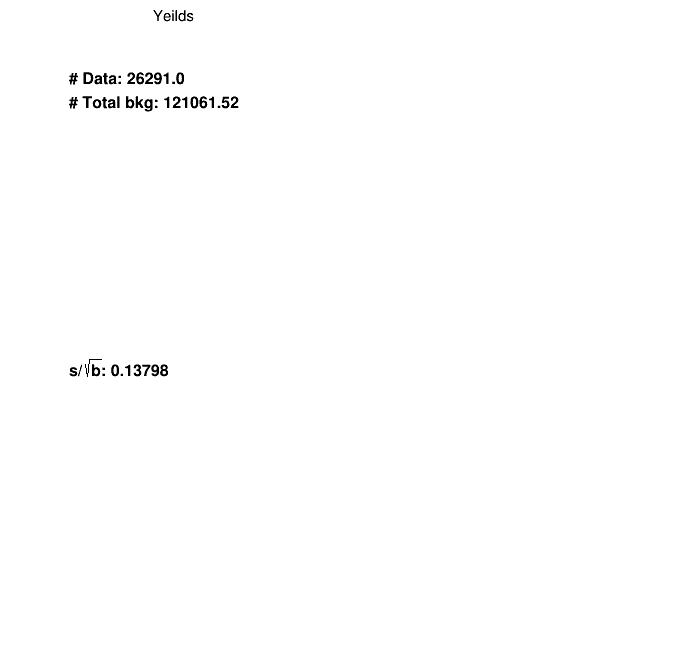

In [22]:
if DRAW_SR:
    region = "SR"

    with Pool() as p:
        p.starmap(wrapper_mp, list_variables) 
#     wrapper_mp('mass_pre', [45, 100, 1000, 'M_{ll} [GeV]'])

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)

In [22]:
###### wotop ######
dic_variable={
    "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
    "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"], 
}
os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wotop")

for variable, r in dic_variable.items():
    if not "Puppi" in variable:
        threshold = 0.3
    else:
        threshold = 0.5
    hist=HistStack(dic_df_raw, variable, "weight", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_"+query_str, blind_from=threshold)        
    hist=HistStack(dic_df_raw, variable, "weighthdampUp", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampUp"+query_str, blind_from=threshold)
    hist=HistStack(dic_df_raw, variable, "weighthdampDown", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampDown"+query_str, blind_from=threshold)
    hist=HistStack(dic_df_raw, variable, "weightPSUp", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEUp"+query_str, blind_from=threshold)
    hist=HistStack(dic_df_raw, variable, "weightPSDown", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEDown"+query_str, blind_from=threshold)
    hist=HistStack(dic_df_raw, variable, "wotop", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/norm_"+query_str, blind_from=threshold) 
hist.get_yeilds()
hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/pie_"+query_str)  

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_595/2763835779.py", line 23, in <module>
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEDown"+query_str, blind_from=threshold)
  File "/eos/home-h/hkwon/SWAN_projects/Zpeak/./Utils/Plotter.py", line 291, in draw_hist
    dic_merged=self.get_merged_hist()
  File "/eos/home-h/hkwon/SWAN_projects/Zpeak/./Utils/Plotter.py", line 37, in get_merged_hist
    hist_all=self.get_dic_hist()
  File "/eos/home-h/hkwon/SWAN_projects/Zpeak/./Utils/Plotter.py", line 30, in get_dic_hist
    h.Fill(v, df[self.weight].iat[i])
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py", line 2103, in __getitem__
    

TypeError: object of type 'NoneType' has no len()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/normblind_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/normblind_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/normblind_hdampUpmass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230514wp80_18/Presel/em18/SR/normblind_hdampUpmass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: 

In [ ]:
dic_df_raw["TT"]["trigSF_pre"]

# Signal Acc x Eff x presel

In [ ]:
str_channel, str_lumi = HistStack.get_str_lumi_channel(ERA, ERA)

Zp_mass=[1700, 2100, 2500, 2900, 3300, 3700, 4100]
CH_mass=[345, 595, 845, 1095, 1345, 1595, 1845]
c1=rt.TCanvas("c1", "c1", 650, 500)
c1.SetLeftMargin(0.15)
c1.SetBottomMargin(0.15)
h2d1=rt.TH2D("h2d1", "", len(Zp_mass), Zp_mass[0]-200, Zp_mass[-1]+200, len(CH_mass), CH_mass[0]-125, CH_mass[-1]+125)
h2d1.SetTitle("Acc x Eff x Presel")

n_sig_in = 150000/4
if "em" in ERA:
    n_sig_in = 150000/2

for key in dic_df_raw:
    if not "Zp" in key:
        continue
    tmp=key.replace('_', '-')
    tmp=tmp.split('-')
    
    MZp=tmp[1]
    MCH=tmp[3]
    binx=Zp_mass.index(int(MZp))+1
    biny=CH_mass.index(int(MCH))+1
    h2d1.SetBinContent(binx, biny, dic_df_raw[key].shape[0]/(n_sig_in))
# # missing bin by hand
# h2d1.SetBinContent(5, 3, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000
# h2d1.SetBinContent(3, 4, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000

# set_palette("rainbow",255)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetPalette(55)

h2d1.Draw("colz text")
h2d1.SetYTitle("m_{#tilde#chi_{1}^{#pm}} [GeV]")
h2d1.SetXTitle("m_{Z'} [GeV]")
h2d1.GetYaxis().SetTitleSize(0.05)
h2d1.GetXaxis().SetTitleSize(0.05)
latex=rt.TLatex()
latex.DrawLatexNDC( 0.2,0.84, "#scale[0.8]{#font[42]{"+str_channel+" channel}}")

latex1=rt.TLatex()
latex1.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
latex1.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
 
c1.Draw()
c1.SaveAs(DATE+"/Presel/"+ERA+"/"+region+"/sig_eff.pdf")

# MET side band

In [ ]:
if RUN_SIDEBAND_MET:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [20, 0, 100, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
    #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
    #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
    #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "METSB"
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [ ]:
if DUMP_SIDEBAND_MET_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_METSB.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# Mass side band

In [ ]:
if RUN_SIDEBAND_MASS and not "em" in ERA:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    
    dic_variable={
        "PuppiMET_pre": [28, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
        "mass_pre": [1,80, 100, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    }

    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "MASSSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "mass_pre", "weight", 1, 80,  100, "M_{ll} [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.get_yeilds()
    hist.create_root_file(file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF"] 
#     sys_list = ["puweight", "l1prefiring", "effSF", "topSF"] 
    for s in sys_list:
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Up', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Down', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist=HistStack(dic_df_met_u_tmp, "mass_pre", 'weightmetUp', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist=HistStack(dic_df_met_d_tmp, "mass_pre", 'weightmetDown', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")      

In [ ]:
if DUMP_SIDEBAND_MASS_PKL and not "em" in ERA:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_MASS.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# PT side band

In [ ]:
if RUN_SIDEBAND_PT:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre<40 and PuppiMET_pre>100"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
        "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
        "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [4, 0, 40, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [14, 0, 660, "U [GeV]"],
#         "JZB_pre": [14, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
#     #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
#     #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
#     #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#         "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
# #         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# #         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "PTSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "hdamp", "PS"]
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [ ]:
if DUMP_SIDEBAND_PT_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_PT.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# b tag selection

In [ ]:
if RUN_BTAG:
    dic_variable={
        "MET_pre": [25, 0, 500, "p_{T}^{miss} [GeV]"],    
#         "PuppiMET_pre": [50, 0, 500, "Puppi p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#         "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
        "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"], 
        "nbjetflav_pre": [10, 0, 10, "N bjetflav"], 
#         "nbjet_pre": [10, 0, 10, "N bjet"], 
        "njet_pre": [10, 0, 10, "N jet"], 
#         "njet_l_pre": [9, 1, 10, "N  l jet"],     
#         "njet_c_pre": [9, 1, 10, "N  c jet"],     
#         "njet_b_pre": [9, 1, 10, "N  b jet"],    
#         "btagSF0_pre": [40, 0.9, 1.3, "B SF"],    
    }
    
#     base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>80 and PuppiMET_pre>150 and MT_pre>130"
    base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    dic_df_raw={}
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and njet_pre==1" #temp!
#     query_str=base_line+" and nbjetflav_pre==0" #temp!
    query_str=base_line #temp!

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)  
        print(key, ":", dic_df_raw[key].shape[0])

    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u
    nested_dic_df["met_d"]=dic_df_met_d
        
    sys_list = ["weight", "wobsf", "wotop"]
    for sys_key in sys_list:
        for variable, r in dic_variable.items():
            os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/Beq0/"+sys_key)
            hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
            c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/Beq0/"+sys_key+"/preselv1_"+query_str) 
    
#     hist=HistStack(dic_df_raw, "btagSF0_pre", "genweight_pre", 40, 0.9, 1.3, "B SF")            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/NONBTAG/"+sys_key+"/genweight_pre_preselv1_"+query_str, is_dnn=False) 

        #simply from last instance
        print(hist.get_yeilds())
        hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/Beq0/"+sys_key+"/pie_"+query_str)
        print(hist.nbin)    
    
#     with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_Beq0.pkl", "wb") as f:
#         pickle.dump(nested_dic_df, f)

# Export variables

In [ ]:
if EXPORT_VARIABLE:
    # draw
    # get plot configuration
    dic_variable={
    #     "pt_trail_pre": [8, 40, 300, "p_{T}(l_{trail}) [GeV]"],
    #     "MT2_pre": [8, 0, 160, "M_{T2} [GeV]"],
        "H3PP_pre": [19, 95, 900, "H3PP [GeV]"],     
    }
    sys_src={
        "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre"]
    #     "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre", "topSF_pre"]
    }
    # sys_src=[]
    for key in dic_df_raw:
        if "Zp" in key:
            for variable, r in dic_variable.items():
                hist=HistStack(dic_df_raw, variable, sys_src, "presel", r[0], r[1], r[2], r[3])            
                c1=hist.draw_hist(key, ERA, ERA+"_exportdev"+query_str, True) 
                hist.create_root_file(key, variable, channel)
                hist.export_hist(key, variable, channel, "") 

    #simply from last instance
    print(hist.get_yeilds())
    hist.draw_pie()
    print(hist.nbin)
